## **Ali Darabi - 810100264**

## **AI - CA5**

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as op
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import random

In [24]:
DATA_SET_PATH = "/kaggle/input/ai-ca5-data-set/AI-CA5-Dataset/"
RESIZED_DATA_SET_PATH = "/kaggle/working/ResizedDataSet/"

for dic in os.listdir(DATA_SET_PATH):
  path_dic = os.path.join(DATA_SET_PATH, dic)
  resized_path_dic = os.path.join(RESIZED_DATA_SET_PATH, dic)
  if not os.path.exists(resized_path_dic):
    os.makedirs(resized_path_dic)

  for pic in os.listdir(path_dic):
    picture = Image.open(os.path.join(path_dic, pic))
    resized = picture.resize((512, 512))
    resized_pic_path = os.path.join(resized_path_dic, pic)
    resized.save(resized_pic_path)

In [25]:
class Tumor_Data_Set(Dataset):
    def __init__(self, indexes):
        self.file_paths = []
        self.file_labels = []
        i = 0
        j = 0
        for label in ["glioma", "meningioma", "notumor", "pituitary"]:
          dir = f"/kaggle/working/ResizedDataSet/{label}"
          for file in os.listdir(dir):
            if file.endswith(".jpg"):
              if (i in indexes):
                self.file_paths.append(os.path.join(dir + "/",file))
                self.file_labels.append(j)
              i = i + 1
          j = j + 1

        self.transform = self.get_transform()

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        pic_path = self.file_paths[index]
        pic_label = self.file_labels[index]
        pic = Image.open(pic_path)
        if (pic.mode != 'RGB'):
            pic = pic.convert('RGB')
        if self.transform:
            pic = self.transform(pic)
        return pic, pic_label

    def get_pic(self, index):
      pic_path = self.file_paths[index]
      pic = Image.open(pic_path)
      if (pic.mode != 'RGB'):
          pic = pic.convert('RGB')
      return pic

    def get_transform(self):
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [26]:
random_index_g = random.sample(range(0, 300), 60)
random_index_m = random.sample(range(300, 606), 61)
random_index_n = random.sample(range(606, 1011), 81)
random_index_p = random.sample(range(1011, 1311), 60)
test_data_index = random_index_g + random_index_m + random_index_n + random_index_p
all_index = list(range(1311))
train_data_index = [idx for idx in all_index if idx not in test_data_index]

In [27]:
data_set_test = Tumor_Data_Set(test_data_index)
data_set_train = Tumor_Data_Set(train_data_index)

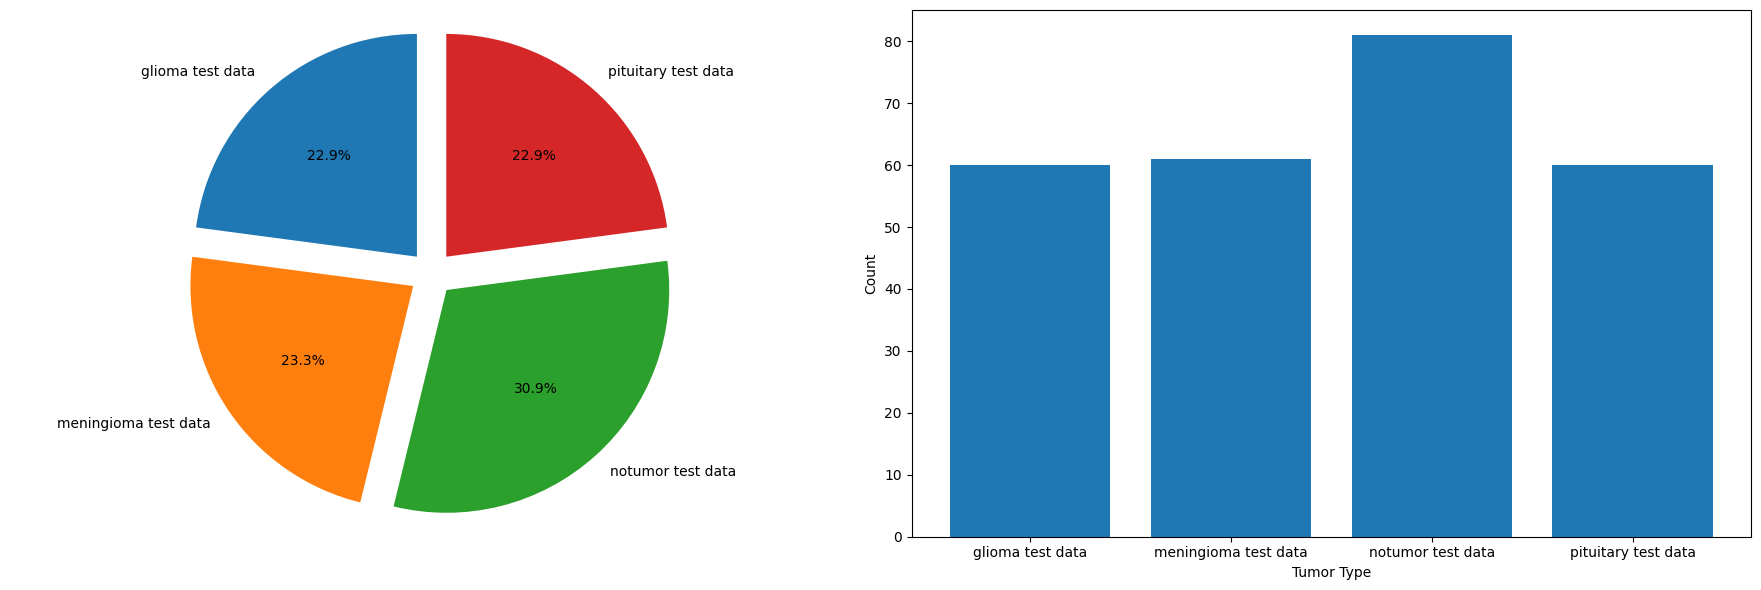

In [28]:
g_test_count = int(0.2 * 300)
m_test_count = int(0.2 * 306)
n_test_count = int(0.2 * 405)
p_test_count = int(0.2 * 300)
labels = ["glioma test data", "meningioma test data", "notumor test data", "pituitary test data"]
sizes = [g_test_count, m_test_count, n_test_count, p_test_count]
explode = (0.1, 0.1, 0.1, 0.1)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(18, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
ax1.bar(labels, sizes)
ax1.set_xlabel('Tumor Type')
ax1.set_ylabel('Count')
fig.tight_layout()
plt.show()

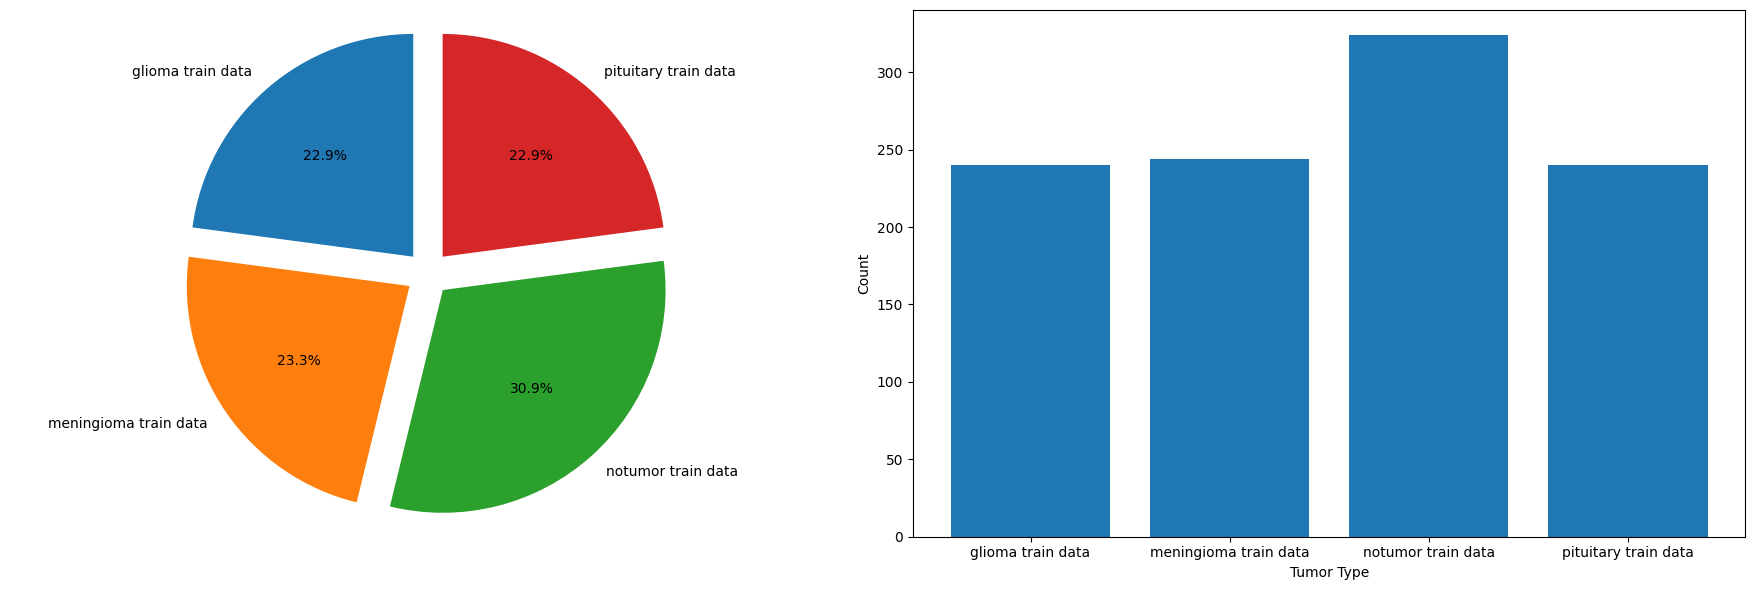

In [29]:
g_train_count = int(0.8 * 300)
m_train_count = int(0.8 * 306)
n_train_count = int(0.8 * 405)
p_train_count = int(0.8 * 300)
labels = ["glioma train data", "meningioma train data", "notumor train data", "pituitary train data"]
sizes = [g_train_count, m_train_count, n_train_count, p_train_count]
explode = (0.1, 0.1, 0.1, 0.1)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(18, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
ax1.bar(labels, sizes)
ax1.set_xlabel('Tumor Type')
ax1.set_ylabel('Count')
fig.tight_layout()
plt.show()

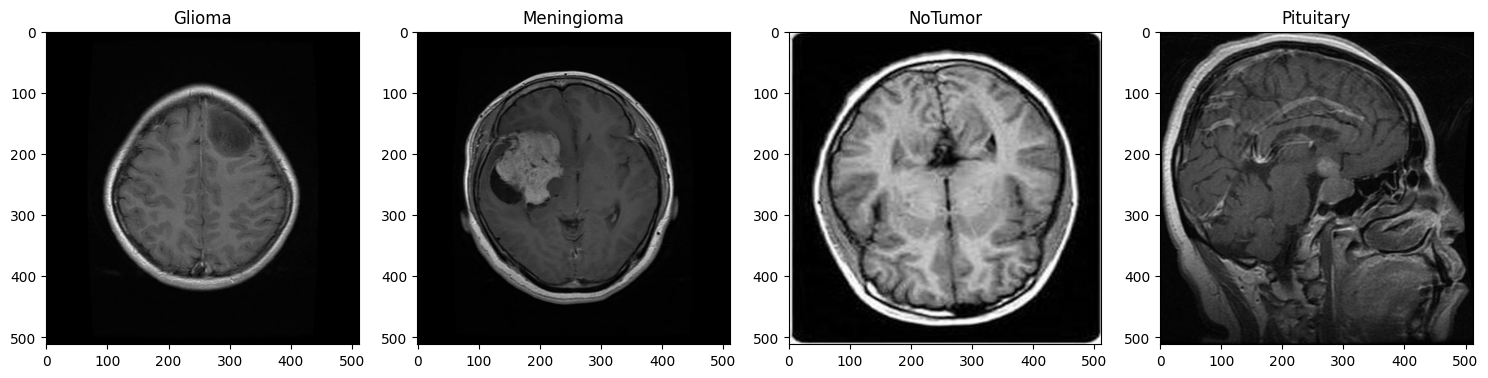

In [30]:
image_glioma = data_set_test.get_pic(30)
image_meningioma = data_set_test.get_pic(80)
image_notumor = data_set_test.get_pic(150)
image_pituitary = data_set_test.get_pic(230)
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(image_glioma)
axs[0].set_title('Glioma')
axs[1].imshow(image_meningioma)
axs[1].set_title('Meningioma')
axs[2].imshow(image_notumor)
axs[2].set_title('NoTumor')
axs[3].imshow(image_pituitary)
axs[3].set_title('Pituitary')
plt.tight_layout()
plt.show()

In [31]:
class Tumor_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Tumor_Classifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(32768, 128),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.Flatten()(x)
        x = self.classifier(x)
        return x

model = Tumor_Classifier(num_classes=4)

In [32]:
loss_func = nn.CrossEntropyLoss()
optimizer = op.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(data_set_train, batch_size=32, shuffle=True)
test_loader = DataLoader(data_set_test, batch_size=32, shuffle=False)

### The key benefit of CrossEntropyLoss is that it combines softmax and NLL loss into one class, which simplifies our code and We don't have to manually apply softmax before passing the outputs into the loss function.

In [33]:
num_epoch = 40
best_val_accuracy = 0
best_epoch_conf_mat = torch.zeros(4, 4)

train_accuracy_list = []
test_accuracy_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epoch):
    model.train()
    correct = 0
    total = 0
    train_loss = 0

    enum_train_loader =  tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, labels) in enum_train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        model.cuda()
        outputs = model(inputs.cuda())
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_accuracy = correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    conf_mat = torch.zeros(4, 4)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for true, pred in zip(labels, predicted):
              conf_mat[true][pred] += 1

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    if test_accuracy > best_val_accuracy:
        best_val_accuracy = test_accuracy
        best_epoch_conf_mat = conf_mat

    print(f'Epoch [{epoch+1}/{num_epoch}], 'f'Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2%}, '
f'Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2%}')

print("Best Test Accuracy: {:.2f}".format(best_val_accuracy*100))

100%|██████████| 33/33 [00:08<00:00,  3.76it/s]


Epoch [1/40], Train Loss: 37.08, Train Accuracy: 52.81%, Test Loss: 0.86, Test Accuracy: 64.12%


100%|██████████| 33/33 [00:08<00:00,  3.71it/s]


Epoch [2/40], Train Loss: 27.92, Train Accuracy: 65.30%, Test Loss: 0.70, Test Accuracy: 68.70%


100%|██████████| 33/33 [00:08<00:00,  3.75it/s]


Epoch [3/40], Train Loss: 22.72, Train Accuracy: 71.88%, Test Loss: 0.53, Test Accuracy: 77.10%


100%|██████████| 33/33 [00:08<00:00,  3.75it/s]


Epoch [4/40], Train Loss: 17.87, Train Accuracy: 78.27%, Test Loss: 0.45, Test Accuracy: 80.92%


100%|██████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch [5/40], Train Loss: 17.03, Train Accuracy: 77.79%, Test Loss: 0.52, Test Accuracy: 77.86%


100%|██████████| 33/33 [00:08<00:00,  3.94it/s]


Epoch [6/40], Train Loss: 14.14, Train Accuracy: 82.75%, Test Loss: 0.45, Test Accuracy: 80.53%


100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


Epoch [7/40], Train Loss: 12.76, Train Accuracy: 84.08%, Test Loss: 0.45, Test Accuracy: 81.30%


100%|██████████| 33/33 [00:08<00:00,  3.71it/s]


Epoch [8/40], Train Loss: 11.04, Train Accuracy: 86.37%, Test Loss: 0.42, Test Accuracy: 83.21%


100%|██████████| 33/33 [00:08<00:00,  3.80it/s]


Epoch [9/40], Train Loss: 9.84, Train Accuracy: 88.75%, Test Loss: 0.53, Test Accuracy: 82.06%


100%|██████████| 33/33 [00:08<00:00,  3.85it/s]


Epoch [10/40], Train Loss: 9.46, Train Accuracy: 88.37%, Test Loss: 0.53, Test Accuracy: 79.39%


100%|██████████| 33/33 [00:08<00:00,  3.77it/s]


Epoch [11/40], Train Loss: 8.24, Train Accuracy: 90.18%, Test Loss: 0.52, Test Accuracy: 82.82%


100%|██████████| 33/33 [00:08<00:00,  3.82it/s]


Epoch [12/40], Train Loss: 7.90, Train Accuracy: 89.51%, Test Loss: 0.50, Test Accuracy: 83.21%


100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


Epoch [13/40], Train Loss: 7.03, Train Accuracy: 92.09%, Test Loss: 0.45, Test Accuracy: 86.64%


100%|██████████| 33/33 [00:08<00:00,  3.74it/s]


Epoch [14/40], Train Loss: 5.87, Train Accuracy: 92.76%, Test Loss: 0.55, Test Accuracy: 85.11%


100%|██████████| 33/33 [00:08<00:00,  3.85it/s]


Epoch [15/40], Train Loss: 5.18, Train Accuracy: 93.80%, Test Loss: 0.46, Test Accuracy: 88.17%


100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


Epoch [16/40], Train Loss: 4.94, Train Accuracy: 94.85%, Test Loss: 0.44, Test Accuracy: 87.79%


100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


Epoch [17/40], Train Loss: 4.63, Train Accuracy: 94.95%, Test Loss: 0.48, Test Accuracy: 87.02%


100%|██████████| 33/33 [00:08<00:00,  3.80it/s]


Epoch [18/40], Train Loss: 4.51, Train Accuracy: 95.23%, Test Loss: 0.50, Test Accuracy: 85.50%


100%|██████████| 33/33 [00:08<00:00,  3.82it/s]


Epoch [19/40], Train Loss: 3.30, Train Accuracy: 95.71%, Test Loss: 0.55, Test Accuracy: 88.55%


100%|██████████| 33/33 [00:08<00:00,  3.70it/s]


Epoch [20/40], Train Loss: 4.67, Train Accuracy: 95.52%, Test Loss: 0.64, Test Accuracy: 86.64%


100%|██████████| 33/33 [00:08<00:00,  3.78it/s]


Epoch [21/40], Train Loss: 3.56, Train Accuracy: 96.47%, Test Loss: 0.62, Test Accuracy: 88.17%


100%|██████████| 33/33 [00:08<00:00,  3.77it/s]


Epoch [22/40], Train Loss: 2.98, Train Accuracy: 96.95%, Test Loss: 0.54, Test Accuracy: 87.40%


100%|██████████| 33/33 [00:08<00:00,  3.70it/s]


Epoch [23/40], Train Loss: 2.75, Train Accuracy: 97.24%, Test Loss: 0.70, Test Accuracy: 87.40%


100%|██████████| 33/33 [00:08<00:00,  3.81it/s]


Epoch [24/40], Train Loss: 3.55, Train Accuracy: 95.42%, Test Loss: 0.56, Test Accuracy: 88.93%


100%|██████████| 33/33 [00:08<00:00,  3.78it/s]


Epoch [25/40], Train Loss: 2.99, Train Accuracy: 97.14%, Test Loss: 0.48, Test Accuracy: 89.31%


100%|██████████| 33/33 [00:08<00:00,  3.74it/s]


Epoch [26/40], Train Loss: 2.92, Train Accuracy: 97.04%, Test Loss: 0.51, Test Accuracy: 87.79%


100%|██████████| 33/33 [00:08<00:00,  3.84it/s]


Epoch [27/40], Train Loss: 2.84, Train Accuracy: 96.76%, Test Loss: 0.60, Test Accuracy: 88.55%


100%|██████████| 33/33 [00:08<00:00,  3.82it/s]


Epoch [28/40], Train Loss: 2.24, Train Accuracy: 98.00%, Test Loss: 0.58, Test Accuracy: 86.26%


100%|██████████| 33/33 [00:08<00:00,  3.72it/s]


Epoch [29/40], Train Loss: 3.23, Train Accuracy: 96.66%, Test Loss: 0.58, Test Accuracy: 89.31%


100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


Epoch [30/40], Train Loss: 1.67, Train Accuracy: 98.09%, Test Loss: 0.55, Test Accuracy: 90.08%


100%|██████████| 33/33 [00:08<00:00,  3.82it/s]


Epoch [31/40], Train Loss: 1.69, Train Accuracy: 98.57%, Test Loss: 0.66, Test Accuracy: 87.40%


100%|██████████| 33/33 [00:08<00:00,  3.69it/s]


Epoch [32/40], Train Loss: 2.48, Train Accuracy: 97.04%, Test Loss: 0.58, Test Accuracy: 88.55%


100%|██████████| 33/33 [00:08<00:00,  3.84it/s]


Epoch [33/40], Train Loss: 2.24, Train Accuracy: 97.62%, Test Loss: 0.74, Test Accuracy: 88.93%


100%|██████████| 33/33 [00:08<00:00,  3.82it/s]


Epoch [34/40], Train Loss: 1.24, Train Accuracy: 98.19%, Test Loss: 0.72, Test Accuracy: 88.55%


100%|██████████| 33/33 [00:08<00:00,  3.76it/s]


Epoch [35/40], Train Loss: 1.50, Train Accuracy: 98.28%, Test Loss: 0.72, Test Accuracy: 89.69%


100%|██████████| 33/33 [00:08<00:00,  3.79it/s]


Epoch [36/40], Train Loss: 2.66, Train Accuracy: 97.33%, Test Loss: 0.60, Test Accuracy: 89.69%


100%|██████████| 33/33 [00:08<00:00,  3.84it/s]


Epoch [37/40], Train Loss: 2.20, Train Accuracy: 97.62%, Test Loss: 0.64, Test Accuracy: 88.17%


100%|██████████| 33/33 [00:08<00:00,  3.74it/s]


Epoch [38/40], Train Loss: 1.79, Train Accuracy: 98.38%, Test Loss: 0.55, Test Accuracy: 89.69%


100%|██████████| 33/33 [00:08<00:00,  3.78it/s]


Epoch [39/40], Train Loss: 1.20, Train Accuracy: 98.76%, Test Loss: 0.78, Test Accuracy: 87.40%


100%|██████████| 33/33 [00:08<00:00,  3.80it/s]


Epoch [40/40], Train Loss: 2.45, Train Accuracy: 98.00%, Test Loss: 0.67, Test Accuracy: 88.93%
Best Test Accuracy: 90.08


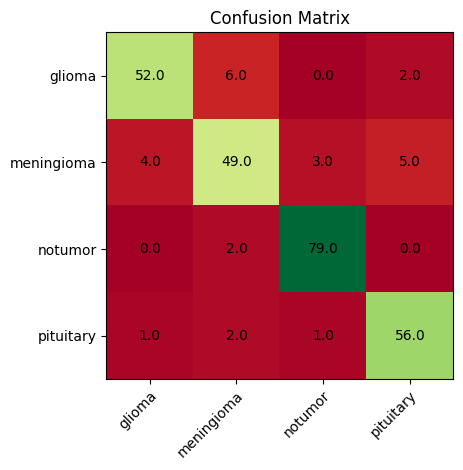

In [34]:
best_epoch_conf_mat = np.array(best_epoch_conf_mat)
labels = ["glioma", "meningioma", "notumor", "pituitary"]
fig, ax = plt.subplots()
im = ax.imshow(best_epoch_conf_mat, cmap="RdYlGn")
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, best_epoch_conf_mat[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

In [35]:
def print_evaluation_metrics(conf_mat):
  print("Accuracy: ", calc_accuracy(conf_mat))
  print("Precision: ", calc_precision(conf_mat))
  print("Recall: ", calc_recall(conf_mat))
  print("F1 Score: ", calc_f1_score(conf_mat))

def calc_accuracy(conf_mat):
  diagonal_sum = conf_mat[0][0] + conf_mat[1][1]
  total = np.sum(conf_mat)
  return diagonal_sum / total

def calc_recall(conf_mat):
  tp = conf_mat[0][0]
  fn = conf_mat[0][1]
  return tp / (tp + fn)

def calc_precision(conf_mat):
  tp = conf_mat[0][0]
  fp = conf_mat[1][0]
  return tp / (tp + fp)

def calc_f1_score(conf_mat):
  p = calc_precision(conf_mat)
  r = calc_recall(conf_mat)
  return 2*(p*r) / (p+r)

In [36]:
def plot_confusion_matrix(conf_mat):
  fig, ax = plt.subplots()
  im = ax.imshow(conf_mat, cmap="RdYlGn")
  ax.set_xticks(np.arange(2), labels=["Positive", "Negative"])
  ax.set_yticks(np.arange(2), labels=["Positive", "Negative"])
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  for i in range(2):
      for j in range(2):
          text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="black")
  ax.set_title("Confusion Matrix")
  fig.tight_layout()
  plt.show()

Accuracy:  0.950381679389313
Precision:  0.9122807017543859
Recall:  0.8666666666666667
F1 Score:  0.8888888888888888


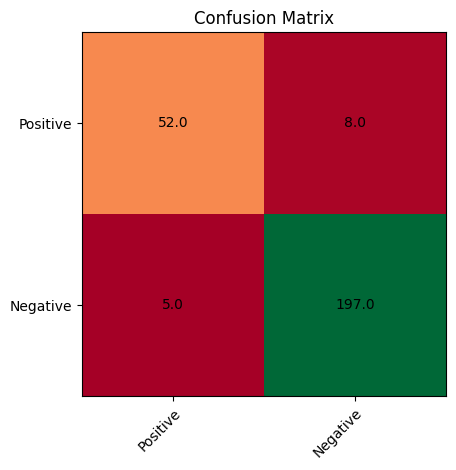

In [37]:
glioma_conf_mat = np.zeros((2,2))
glioma_conf_mat[0][0] = best_epoch_conf_mat[0][0]
glioma_conf_mat[0][1] = best_epoch_conf_mat[0][1] + best_epoch_conf_mat[0][2] + best_epoch_conf_mat[0][3]
glioma_conf_mat[1][0] = best_epoch_conf_mat[1][0] + best_epoch_conf_mat[2][0] + best_epoch_conf_mat[3][0]
glioma_conf_mat[1][1] = best_epoch_conf_mat[1][1] + best_epoch_conf_mat[1][2] + best_epoch_conf_mat[1][3]
glioma_conf_mat[1][1] += best_epoch_conf_mat[2][1] + best_epoch_conf_mat[2][2] + best_epoch_conf_mat[2][3]
glioma_conf_mat[1][1] += best_epoch_conf_mat[3][1] + best_epoch_conf_mat[3][2] + best_epoch_conf_mat[3][3]
print_evaluation_metrics(glioma_conf_mat)
plot_confusion_matrix(glioma_conf_mat)

Accuracy:  0.916030534351145
Precision:  0.8305084745762712
Recall:  0.8032786885245902
F1 Score:  0.8166666666666667


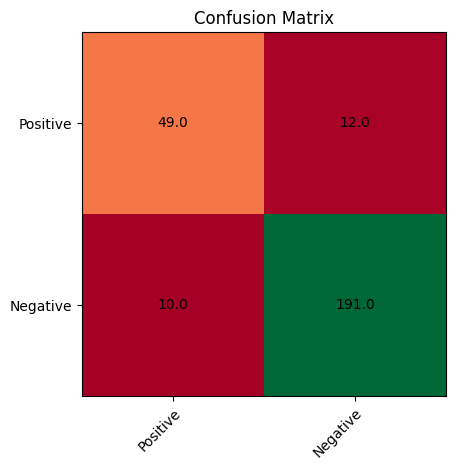

In [38]:
meningioma_conf_mat = np.zeros((2,2))
meningioma_conf_mat[0][0] = best_epoch_conf_mat[1][1]
meningioma_conf_mat[0][1] = best_epoch_conf_mat[1][0] + best_epoch_conf_mat[1][2] + best_epoch_conf_mat[1][3]
meningioma_conf_mat[1][0] = best_epoch_conf_mat[0][1] + best_epoch_conf_mat[2][1] + best_epoch_conf_mat[3][1]
meningioma_conf_mat[1][1] = best_epoch_conf_mat[0][0] + best_epoch_conf_mat[0][2] + best_epoch_conf_mat[0][3]
meningioma_conf_mat[1][1] += best_epoch_conf_mat[2][0] + best_epoch_conf_mat[2][2] + best_epoch_conf_mat[2][3]
meningioma_conf_mat[1][1] += best_epoch_conf_mat[3][0] + best_epoch_conf_mat[3][2] + best_epoch_conf_mat[3][3]
print_evaluation_metrics(meningioma_conf_mat)
plot_confusion_matrix(meningioma_conf_mat)

Accuracy:  0.9770992366412213
Precision:  0.9518072289156626
Recall:  0.9753086419753086
F1 Score:  0.9634146341463414


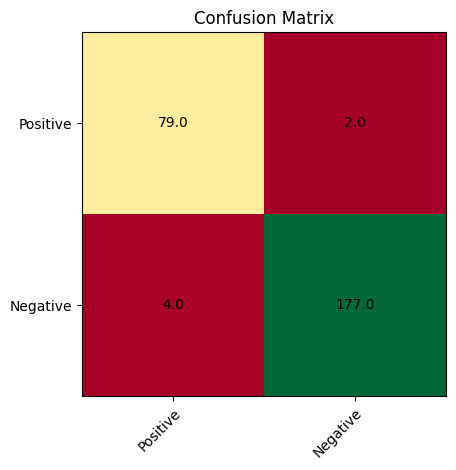

In [39]:
notumor_conf_mat = np.zeros((2,2))
notumor_conf_mat[0][0] = best_epoch_conf_mat[2][2]
notumor_conf_mat[0][1] = best_epoch_conf_mat[2][0] + best_epoch_conf_mat[2][1] + best_epoch_conf_mat[2][3]
notumor_conf_mat[1][0] = best_epoch_conf_mat[0][2] + best_epoch_conf_mat[1][2] + best_epoch_conf_mat[3][2]
notumor_conf_mat[1][1] = best_epoch_conf_mat[0][0] + best_epoch_conf_mat[0][1] + best_epoch_conf_mat[0][3]
notumor_conf_mat[1][1] += best_epoch_conf_mat[1][0] + best_epoch_conf_mat[1][1] + best_epoch_conf_mat[1][3]
notumor_conf_mat[1][1] += best_epoch_conf_mat[3][0] + best_epoch_conf_mat[3][1] + best_epoch_conf_mat[3][3]
print_evaluation_metrics(notumor_conf_mat)
plot_confusion_matrix(notumor_conf_mat)

Accuracy:  0.9580152671755725
Precision:  0.8888888888888888
Recall:  0.9333333333333333
F1 Score:  0.9105691056910569


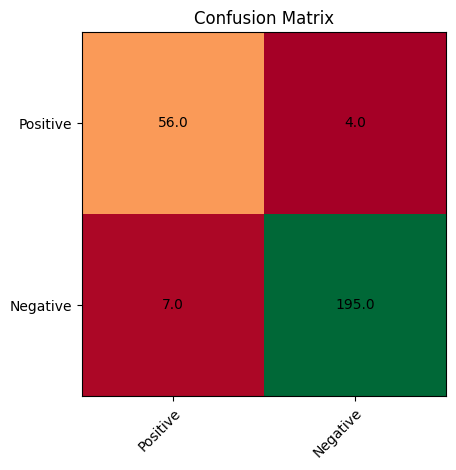

In [40]:
pituitary_conf_mat = np.zeros((2,2))
pituitary_conf_mat[0][0] = best_epoch_conf_mat[3][3]
pituitary_conf_mat[0][1] = best_epoch_conf_mat[3][0] + best_epoch_conf_mat[3][1] + best_epoch_conf_mat[3][2]
pituitary_conf_mat[1][0] = best_epoch_conf_mat[0][3] + best_epoch_conf_mat[1][3] + best_epoch_conf_mat[2][3]
pituitary_conf_mat[1][1] = best_epoch_conf_mat[0][0] + best_epoch_conf_mat[0][1] + best_epoch_conf_mat[0][2]
pituitary_conf_mat[1][1] += best_epoch_conf_mat[1][0] + best_epoch_conf_mat[1][1] + best_epoch_conf_mat[1][2]
pituitary_conf_mat[1][1] += best_epoch_conf_mat[2][0] + best_epoch_conf_mat[2][1] + best_epoch_conf_mat[2][2]
print_evaluation_metrics(pituitary_conf_mat)
plot_confusion_matrix(pituitary_conf_mat)

In [41]:
#Macro Average:
print("Macro Accuracy: ", (calc_accuracy(glioma_conf_mat) + calc_accuracy(meningioma_conf_mat) +
                           calc_accuracy(notumor_conf_mat) + calc_accuracy(pituitary_conf_mat))/4)
print("Macro Precision: ", (calc_precision(glioma_conf_mat) + calc_precision(meningioma_conf_mat) +
                           calc_precision(notumor_conf_mat) + calc_precision(pituitary_conf_mat))/4)
print("Macro Recall: ", (calc_recall(glioma_conf_mat) + calc_recall(meningioma_conf_mat) +
                           calc_recall(notumor_conf_mat) + calc_recall(pituitary_conf_mat))/4)
print("Macro F1 Score: ", (calc_f1_score(glioma_conf_mat) + calc_f1_score(meningioma_conf_mat) +
                           calc_f1_score(notumor_conf_mat) + calc_f1_score(pituitary_conf_mat))/4)

Macro Accuracy:  0.950381679389313
Macro Precision:  0.8958713235338022
Macro Recall:  0.8946468326249748
Macro F1 Score:  0.8948848238482384


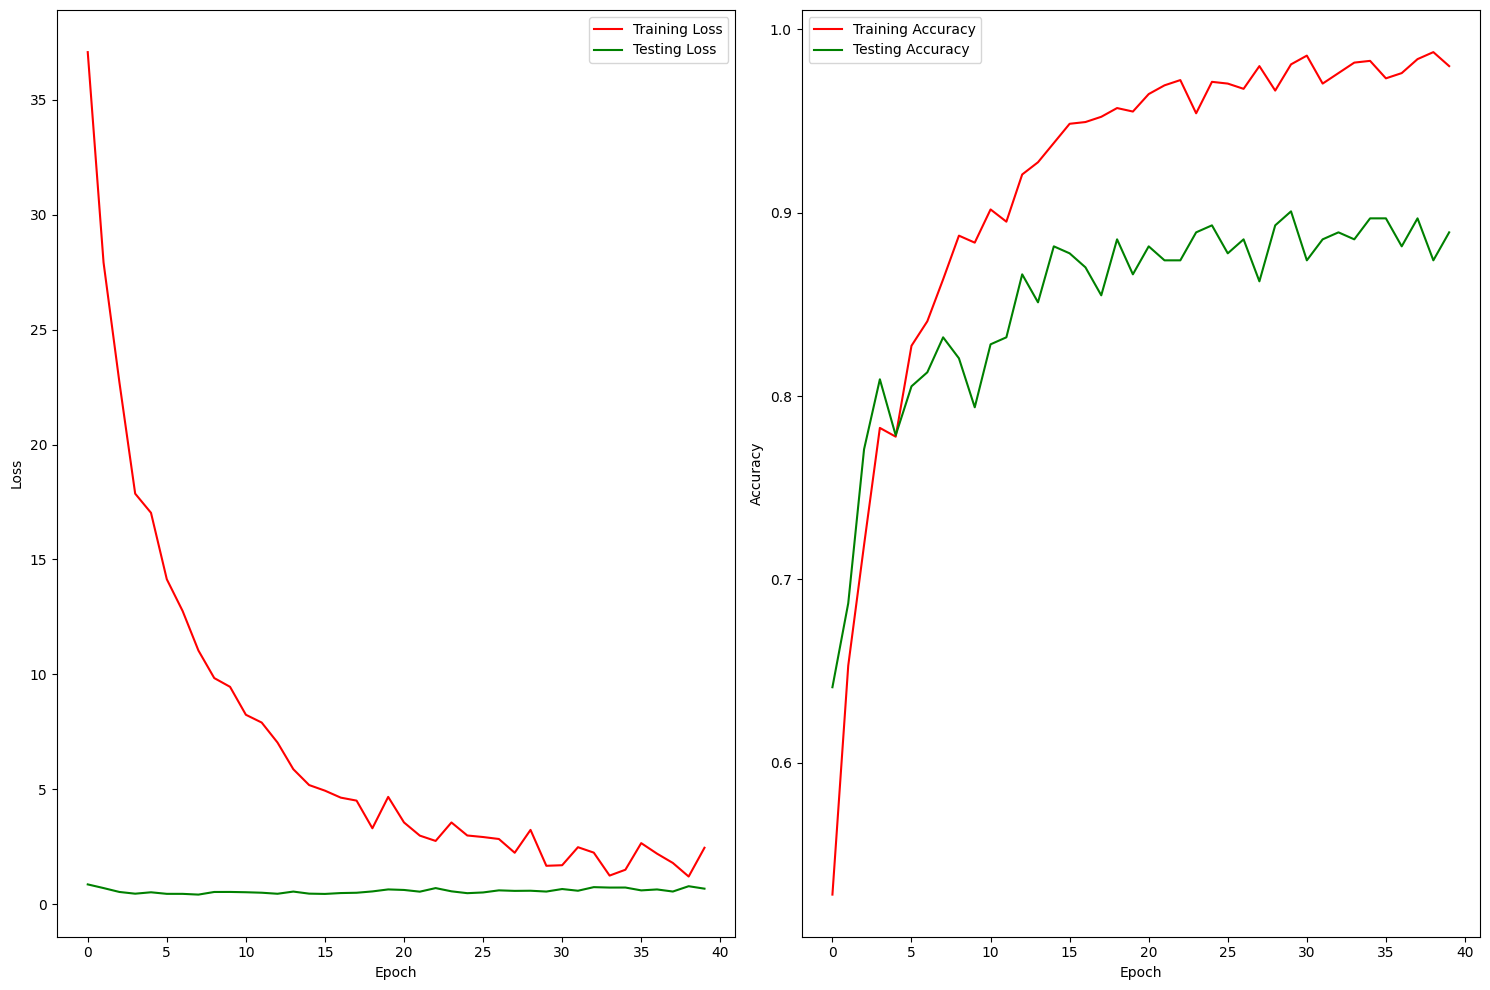

In [42]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, 'r', label='Training Loss')
plt.plot(test_loss_list, 'g', label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, 'r', label='Training Accuracy')
plt.plot(test_accuracy_list, 'g', label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()